```{currentmodule} tskit
```

In [1]:
import io
import pickle

import msprime
import tskit

def tree_traversals():
    nodes = """\
    id      is_sample   time
    0       1           0
    1       1           0
    2       1           0
    3       1           0
    4       1           0
    5       0           1
    6       0           2
    7       0           3
    """
    edges = """\
    left    right   parent  child
    0       1       5       0,1,2
    0       1       6       3,4
    0       1       7       5,6
    """
    # NB same tree as used above, and we're using the same diagram.
    ts = tskit.load_text(
        nodes=io.StringIO(nodes), edges=io.StringIO(edges), strict=False
    )
    ts.dump("data/tree_traversals.trees")

def different_time_samples():
    samples = [
        msprime.Sample(0, 0),
        msprime.Sample(0, 1),
        msprime.Sample(0, 20),
    ]
    ts = msprime.simulate(
        Ne=1e6,
        samples=samples,
        demographic_events=[
            msprime.PopulationParametersChange(time=10, growth_rate=2, population_id=0),
        ],
        random_seed=42,
    )
    ts.dump("data/different_time_samples.trees")

def parsimony_simple():
    ts = msprime.sim_ancestry(3, random_seed=42)
    ts.dump("data/parsimony_simple.trees")

def parsimony_map():
    # pick a seed that gives the tips in the right order
    ts = msprime.sim_ancestry(3, sequence_length=100, random_seed=38)
    ts.dump("data/parsimony_map.trees")
    ts = msprime.sim_mutations(
        ts, rate=0.01, random_seed=123, discrete_genome=False)
    data = [
        {'pos':v.site.position, 'alleles': v.alleles, 'genotypes':v.genotypes}
        for v in ts.variants()]
    with open("data/parsimony_map.pickle", "wb") as f:
        pickle.dump(data, f)


def create_notebook_data():
    tree_traversals()
    different_time_samples()
    parsimony_simple()
    parsimony_map()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_analysing_trees)=
# Analysing trees

There are a number of different ways we might want to analyse a single  {class}`Tree`.
Most involve some sort of traversal over the nodes, mutations, or branches in the tree.
{program}`tskit` provides various way of traversing through a tree, and also some
built in phylogenetic algorithms such as {meth}`Tree.map_mutations` which efficently
places mutations ("characters" in phylogenetic terminology) on a given tree.


(sec_analysing_trees_traversals)=

## Tree traversals

Given a single {class}`Tree`, traversals in various orders are possible using the
{meth}`~Tree.nodes` iterator. Take the following tree:

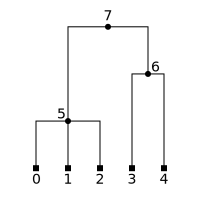

In [2]:
import tskit

ts = tskit.load("data/tree_traversals.trees")
tree = ts.first()
tree.draw_svg()

We can visit the nodes in different orders by providing an `order` parameter to
the {meth}`Tree.nodes` iterator:

In [3]:
for order in ["preorder", "inorder", "postorder"]:
    print(f"{order}:\t", list(tree.nodes(order=order)))

preorder:	 [7, 5, 0, 1, 2, 6, 3, 4]
inorder:	 [0, 5, 1, 2, 7, 3, 6, 4]
postorder:	 [0, 1, 2, 5, 3, 4, 6, 7]


Much of the time, the specific ordering of the nodes is not important
and we can leave it out (defaulting to preorder traversal). For example,
here we compute the total branch length of a tree:

In [4]:
total_branch_length = sum(tree.branch_length(u) for u in tree.nodes())
print(f"Total branch length: {total_branch_length}")

Total branch length: 10.0


Note that this is also available as the {attr}`Tree.total_branch_length` attribute.

### Traversing upwards

For many applications it is useful to be able to traverse upwards from the
leaves. We can do this using the {meth}`Tree.parent` method, which
returns the parent of a node. For example, we can traverse upwards from
each of the samples in the tree:

In [5]:
for u in tree.samples():
    path = []
    v = u
    while v != tskit.NULL:
        path.append(v)
        v = tree.parent(v)
    print(u, "->", path)

0 -> [0, 5, 7]
1 -> [1, 5, 7]
2 -> [2, 5, 7]
3 -> [3, 6, 7]
4 -> [4, 6, 7]


### Traversals with information

Sometimes we will need to traverse down the tree while maintaining
some information about the nodes that are above it. While this
can be done using recursive algorithms, it is often more convenient
and efficient to use an iterative approach. Here, for example,
we define an iterator that yields all nodes in preorder along with
their path length to root:

In [6]:
def preorder_dist(tree):
    for root in tree.roots:
        stack = [(root, 0)]
        while len(stack) > 0:
            u, distance = stack.pop()
            yield u, distance
            for v in tree.children(u):
                stack.append((v, distance + 1))

print(list(preorder_dist(tree)))

[(7, 0), (6, 1), (4, 2), (3, 2), (5, 1), (2, 2), (1, 2), (0, 2)]


(sec_tutorial_networkx)=

## Networkx

Traversals and other network analysis can also be performed using the sizeable
[networkx](https://networkx.github.io/documentation/stable/index.html)
library. This can be achieved by calling {meth}`Tree.as_dict_of_dicts` to
convert a {class}`Tree` instance to a format that can be imported by networkx to
create a graph:

In [7]:
import networkx as nx

g = nx.DiGraph(tree.as_dict_of_dicts())
print(sorted(g.edges))

[(5, 0), (5, 1), (5, 2), (6, 3), (6, 4), (7, 5), (7, 6)]


### Traversing upwards in networkx

We can revisit the above examples and traverse upwards with
networkx using a depth-first search algorithm:

In [8]:
g = nx.DiGraph(tree.as_dict_of_dicts())
for u in tree.samples():
    path = [u] + [parent for parent, child, _ in
                  nx.edge_dfs(g, source=u, orientation="reverse")]
    print(u, "->", path)

0 -> [0, 5, 7]
1 -> [1, 5, 7]
2 -> [2, 5, 7]
3 -> [3, 6, 7]
4 -> [4, 6, 7]


### Calculating distances to the root

Similarly, we can yield the nodes of a tree along with their distance to the
root in pre-order in networkx as well. Running this on the example above gives us
the same result as before:

In [9]:
g = nx.DiGraph(tree.as_dict_of_dicts())
for root in tree.roots:
    print(sorted(list(nx.shortest_path_length(g, source=root).items())))

[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 0)]


### Finding nearest neighbors

If some samples in a tree are not at time 0, then finding the nearest neighbor
of a sample is a bit more involved. Instead of writing our own traversal code
we can again draw on a networkx algorithm.
Let us start with an example tree with three samples that were sampled at
different time points:

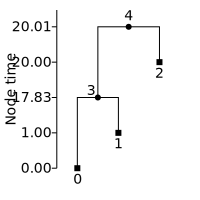

In [10]:
ts = tskit.load("data/different_time_samples.trees")
tree = ts.first()
tree.draw_svg(y_axis=True, time_scale="rank")

The generation times for these nodes are as follows:

In [11]:
for u in tree.nodes():
    print(f"Node {u}: time {tree.time(u)}")

Node 4: time 20.00539877826333
Node 2: time 20.0
Node 3: time 17.833492457579652
Node 0: time 0.0
Node 1: time 1.0


Note that samples 0 and 1 are about 35 generations apart from each other even though
they were sampled at almost the same time. This is why samples 0 and 1 are
closer to sample 2 than to each other.

For this nearest neighbor search we will be traversing up and down the tree,
so it is easier to treat the tree as an undirected graph:

In [12]:
g = nx.Graph(tree.as_dict_of_dicts())

When converting the tree to a networkx graph the edges are annotated with their
branch length:

In [13]:
for e in g.edges(data=True):
    print(e)

(4, 2, {'branch_length': 0.0053987782633306836})
(4, 3, {'branch_length': 2.1719063206836786})
(3, 0, {'branch_length': 17.833492457579652})
(3, 1, {'branch_length': 16.833492457579652})


We can now use the "branch_length" field as a weight for a weighted shortest path
search:

In [14]:
import collections
import itertools

# a dictionary of dictionaries to represent our distance matrix
dist_dod = collections.defaultdict(dict)
for source, target in itertools.combinations(tree.samples(), 2):
    dist_dod[source][target] = nx.shortest_path_length(
        g, source=source, target=target, weight="branch_length"
    )
    dist_dod[target][source] = dist_dod[source][target]

# extract the nearest neighbor of nodes 0, 1, and 2
nearest_neighbor_of = [min(dist_dod[u], key=dist_dod[u].get) for u in range(3)]

print(dict(zip(range(3), nearest_neighbor_of)))

{0: 2, 1: 2, 2: 1}


(sec_analysing_trees_parsimony)=

## Parsimony

Take a site on the following tree with three allelic states, where the
samples are coloured by the allele they possess, but where we don't know
the position of the mutations that caused this variation:

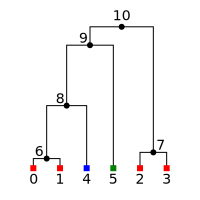

In [15]:
tree = tskit.load("data/parsimony_simple.trees").first()
alleles = ["red", "blue", "green"]
genotypes = [0, 0, 0, 0, 1, 2]
styles = [f".n{j} > .sym {{fill: {alleles[g]}}}" for j, g in enumerate(genotypes)]
tree.draw_svg(style="".join(styles))

The {meth}`Tree.map_mutations` method finds a parsimonious explanation for a
set of discrete character observations on the samples in a tree using classical
phylogenetic algorithms:

In [16]:
ancestral_state, mutations = tree.map_mutations(genotypes, alleles)
print("Ancestral state = ", ancestral_state)
for mut in mutations:
    print(f"Mutation: node = {mut.node} derived_state = {mut.derived_state}")

Ancestral state =  red
Mutation: node = 4 derived_state = blue
Mutation: node = 5 derived_state = green


In this case, the algorithm has concluded, quite reasonably, that the most parsimonious
description of this state is that the ancestral state is red and there was
a mutation to blue and green over nodes 4 and 5.

### Building tables

Below we show how a set of tables can be updated using the
{ref}`Tables API<tskit:sec_tables_api>`, taking advantage of the
{meth}`Tree.map_mutations` method to identify parsimonious positions
for mutations on a tree. Here's the tree we'll use:

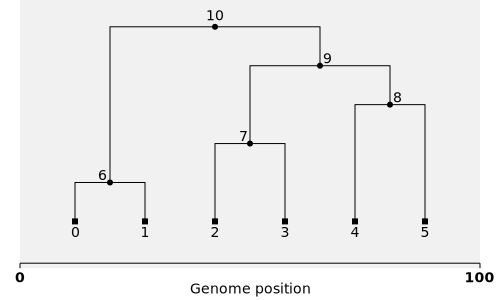

In [17]:
import pickle
ts = tskit.load("data/parsimony_map.trees")
ts.draw_svg(size=(500, 300), time_scale="rank")

Now we can modify the tables by adding mutations. To find the location of mutations,
we infer them from some observed data (some site positions with associated genotypes
and allelic states, in the conventional {class}`tskit encoding <Variant>`):

In [18]:
with open("data/parsimony_map.pickle", "rb") as file:
    data = pickle.load(file)  # Load saved variant data from a file
print("Variant data: each site has a position, allele list, and genotypes array:")
for i, v in enumerate(data):
    print(f"Site {i} (pos {v['pos']:7.4f}): alleles: {v['alleles']}, genotypes: {v['genotypes']}")
print()
tree = ts.first()  # there's only one tree anyway
tables = ts.dump_tables()
# Infer the sites and mutations from the variants.
for variant in data:
    ancestral_state, mutations = tree.map_mutations(variant["genotypes"], variant['alleles'])
    site_id = tables.sites.add_row(variant['pos'], ancestral_state=ancestral_state)
    info = f"Site {site_id}: parsimony sets ancestral state to {ancestral_state}"
    parent_offset = len(tables.mutations)
    for mut in mutations:
        parent = mut.parent
        if parent != tskit.NULL:
            parent += parent_offset
        mut_id = tables.mutations.add_row(
            site_id, node=mut.node, parent=parent, derived_state=mut.derived_state)
        info += f", and places mutation {mut_id} to {mut.derived_state} above node {mut.node}"
    print(info)
new_ts = tables.tree_sequence()

Variant data: each site has a position, allele list, and genotypes array:
Site 0 (pos  8.3726): alleles: ('G', 'A'), genotypes: [1 1 0 0 0 0]
Site 1 (pos 24.4759): alleles: ('T', 'C'), genotypes: [0 0 0 0 1 1]
Site 2 (pos 34.3178): alleles: ('G', 'T'), genotypes: [0 0 1 1 0 0]
Site 3 (pos 39.2118): alleles: ('G', 'C'), genotypes: [0 0 1 1 0 0]
Site 4 (pos 44.0257): alleles: ('G', 'C'), genotypes: [1 1 0 0 0 0]
Site 5 (pos 48.0932): alleles: ('C', 'G'), genotypes: [0 0 1 1 0 0]
Site 6 (pos 68.4830): alleles: ('C', 'G'), genotypes: [0 0 1 1 0 0]
Site 7 (pos 69.4755): alleles: ('A', 'C'), genotypes: [0 0 0 0 1 1]
Site 8 (pos 71.2330): alleles: ('C', 'T'), genotypes: [1 1 0 0 0 0]
Site 9 (pos 71.9150): alleles: ('G', 'T'), genotypes: [0 0 0 0 0 1]

Site 0: parsimony sets ancestral state to G, and places mutation 0 to A above node 6
Site 1: parsimony sets ancestral state to T, and places mutation 1 to C above node 8
Site 2: parsimony sets ancestral state to G, and places mutation 2 to T abo

And here are the parsimoniously positioned mutations on the tree

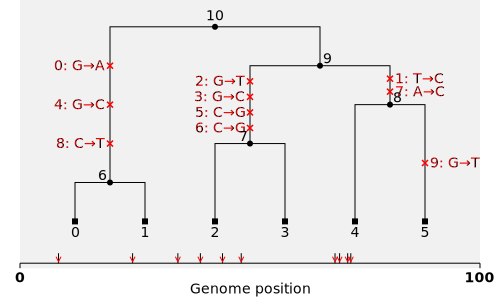

In [19]:
mut_labels = {}  # An array of labels for the mutations
for mut in new_ts.mutations():  # Make pretty labels showing the change in state
    site = new_ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = new_ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[site.id] = f"{mut.id}: {prev}→{mut.derived_state}"

new_ts.draw_svg(size=(500, 300), mutation_labels=mut_labels, time_scale="rank")

### Parsimony and missing data

We can also take missing data
into account when finding a set of parsimonious state transitions. We do this by
specifying the special value {data}`tskit.MISSING_DATA` (-1) as the state, which is
treated by the algorithm as "could be anything".

For example, here we state that sample 0 is missing, indicated by the colour white:

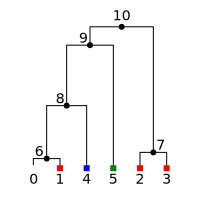

In [20]:
tree = tskit.load("data/parsimony_simple.trees").first()
alleles = ["red", "blue", "green", "white"]
genotypes = [tskit.MISSING_DATA, 0, 0, 0, 1, 2]
styles = [f".n{j} > .sym {{fill: {alleles[g]}}}" for j, g in enumerate(genotypes)]
tree.draw_svg(style="".join(styles))

Now we run the {meth}`Tree.map_mutations` method, which applies the Hartigan parsimony
algorithm:

In [21]:
ancestral_state, mutations = tree.map_mutations(genotypes, alleles)
print("Ancestral state = ", ancestral_state)
for mut in mutations:
    print(f"Mutation: node = {mut.node} derived_state = {mut.derived_state}")

Ancestral state =  red
Mutation: node = 4 derived_state = blue
Mutation: node = 5 derived_state = green


The algorithm decided, again, quite reasonably, that the most parsimonious explanation
for the input data is the same as before. Thus, if we used this information to fill
out mutation table as above, we would impute the missing value for 0 as red.

The output of the algorithm can be a little surprising at times. Consider this example::

Ancestral state =  red
Mutation: node = 6 derived_state = blue


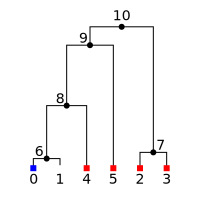

In [22]:
tree = msprime.simulate(6, random_seed=42).first()
alleles = ["red", "blue", "white"]
genotypes = [1, -1, 0, 0, 0, 0]
node_colours = {j: alleles[g] for j, g in enumerate(genotypes)}
ancestral_state, mutations = tree.map_mutations(genotypes, alleles)
print("Ancestral state = ", ancestral_state)
for mut in mutations:
    print(f"Mutation: node = {mut.node} derived_state = {mut.derived_state}")
tree.draw(node_colours=node_colours)

Note that this is putting a mutation to blue over node 6, **not** node 0 as
we might expect. Thus, we impute here that node 1 is blue. It is important
to remember that the algorithm is minimising the number of state transitions;
this may not correspond always to what we might consider the most parsimonious
explanation.

## Fast tree-based algorithms using numba

:::{todo}
Add a few examples here of how to use numba to speed up tree based dynamic programming
algorithms. There are a good number of worked-up examples with timings in
[issue #63](https://github.com/tskit-dev/tutorials/issues/63)
:::